# Book ratings EDA

## 0. Set up

Libraries

In [18]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import datetime

# EDA functions
from EDA_functions import ratings_cleaning_steps
from EDA_functions import folders_set_up

# import requests
# from bs4 import BeautifulSoup
# from PIL import Image
# from io import BytesIO

Project folder

In [20]:
github_folder, input_folder, output_folder = folders_set_up.generate_folders()

## 1. Import data

In [21]:
amz_ratings = pd.read_csv(os.path.join(input_folder,'Books_rating.csv'))

## 2. EDA

Explore data types and head

In [22]:
amz_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


Seems that all data is in the correct format except for review/time

In [23]:
amz_ratings.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


-> Questions/Notes:
- what is review/helpfulness? helpfulness rating of the review 
    - this doesn't seem relevant for our analysis
- price is NA for some observations
    - how many?
    - could this be an issue for our analysis?
- what is review/time? time of given the review 
    - doesn't seem relevant for our analysis but it will need to be converted in datetime if we want to use it

#### 2.1 Title as identifier of the ratings

How many titles are available?

In [24]:
# Count number of tiles
print(f"{amz_ratings['Title'].unique().shape[0]:,}")

212,404


In [25]:
# Make titles lower case to avoid false duplicates
# step skipped to ensure maximum matches with the books dataset
#amz_ratings['Title'] = ratings_cleaning_steps.text_in_lower_case(amz_ratings, 'Title')

In [26]:
# Count number of tiles now that they are all in lower case
print(f"{amz_ratings['Title'].unique().shape[0]:,}")

212,404


-> Questions: 
- does this number match the number of titles available in the amazon_books dataset?
- there may be additional cleaning needed

### 2.2 Missing values

Which columns contain missing values?

In [27]:
amz_ratings.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

-> Questions/notes:
- there are some entries with a missing title
    - these need to be dropped
- price is missing for many entries 
    - is this problematic for our analysis?
    - is it possible to fill this information with other prices for the same title?
- not a big issue if user id and profile names are missing
- good that score is not missing for any title
- missing review summary and text should not be an issue

#### 2.2.1 Title

There are 208 reviews with a missing title.
These are currently not dropped as there is an entry with missing title in the books dataset as well

In [28]:
# Remove na titles with function designed for the EDA
# step skipped to ensure maximum matches with the books dataset
# amz_ratings = ratings_cleaning_steps.remove_na_titles(
#     amz_ratings, 
#     'Title')

In [29]:
# Check that na titles have been removed
amz_ratings[amz_ratings['Title'].isna()]['Title'].count()

0

In [30]:
# Count number of tiles
print(f"{amz_ratings['Title'].unique().shape[0]:,}")

212,404


-> Questions/Note:
- issue sorted

#### 2.2.2 Price
- How many titles have at least one review with a missing price?
- How many titles have only NA prices?

In [31]:
# Create a dataset where we count the number of reviews and the number of reviews with missing price

# 1 Number of ratings per title

count_ratings = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings,
    group_by_columns = 'Title',
    col_to_aggregate = 'Id',
    operation = 'count',
    new_name_for_col_aggregated= 'reviews number'
)

# 2 Number of ratings with na price
na_prices = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings[amz_ratings['Price'].isna()],
    group_by_columns = 'Title',
    col_to_aggregate = 'Id',
    operation = 'count',
    new_name_for_col_aggregated= 'reviews with missing price'
)


# 3 Average rating
avg_ratings = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings,
    group_by_columns = 'Title',
    col_to_aggregate = 'review/score',
    operation = 'average',
    new_name_for_col_aggregated= 'average rating'
)

# 4 Median rating
median_ratings = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings,
    group_by_columns = 'Title',
    col_to_aggregate = 'review/score',
    operation = 'median',
    new_name_for_col_aggregated= 'median rating'
)

# 5 Average price
avg_price = ratings_cleaning_steps.aggregate_df(
    df= amz_ratings[~amz_ratings['Price'].isna()],
    group_by_columns='Title',
    col_to_aggregate='Price',
    operation='average',
    new_name_for_col_aggregated= 'average price'
)

# 6 Median price
median_price = ratings_cleaning_steps.aggregate_df(
    df= amz_ratings[~amz_ratings['Price'].isna()],
    group_by_columns='Title',
    col_to_aggregate='Price',
    operation='median',
    new_name_for_col_aggregated = 'median price'
)

In [32]:
# Merge all datasets together

#title_level_df = pd.DataFrame(columns=['Title'])

df_list = [avg_ratings, median_ratings, na_prices, avg_price, median_price]

title_level_df = count_ratings
for df in df_list:
    title_level_df = pd.merge(
        title_level_df,
        df,
        on = 'Title',
        how ='left'
    )

In [33]:
# titles with no missing price are indicated with NA 'percentage missing prices', replace these with 0
title_level_df['reviews with missing price'] = title_level_df['reviews with missing price'].fillna(0)


# Calculate % of entries with missing prices for each title
title_level_df['percentage missing prices'] = title_level_df['reviews with missing price']/title_level_df['reviews number']

In [34]:
# Histogram settings
bin_size = 0.1
n_bins = int(1/bin_size)+1

# Footnotes
tot_books = title_level_df['reviews number'].count()
tot_books_no_price = title_level_df[title_level_df['percentage missing prices'] == 1]['Title'].count()
tot_books_all_price = title_level_df[title_level_df['percentage missing prices'] == 0]['Title'].count()
tot_books_no_price_perc = tot_books_no_price/tot_books
tot_books_all_price_perc = tot_books_all_price/tot_books

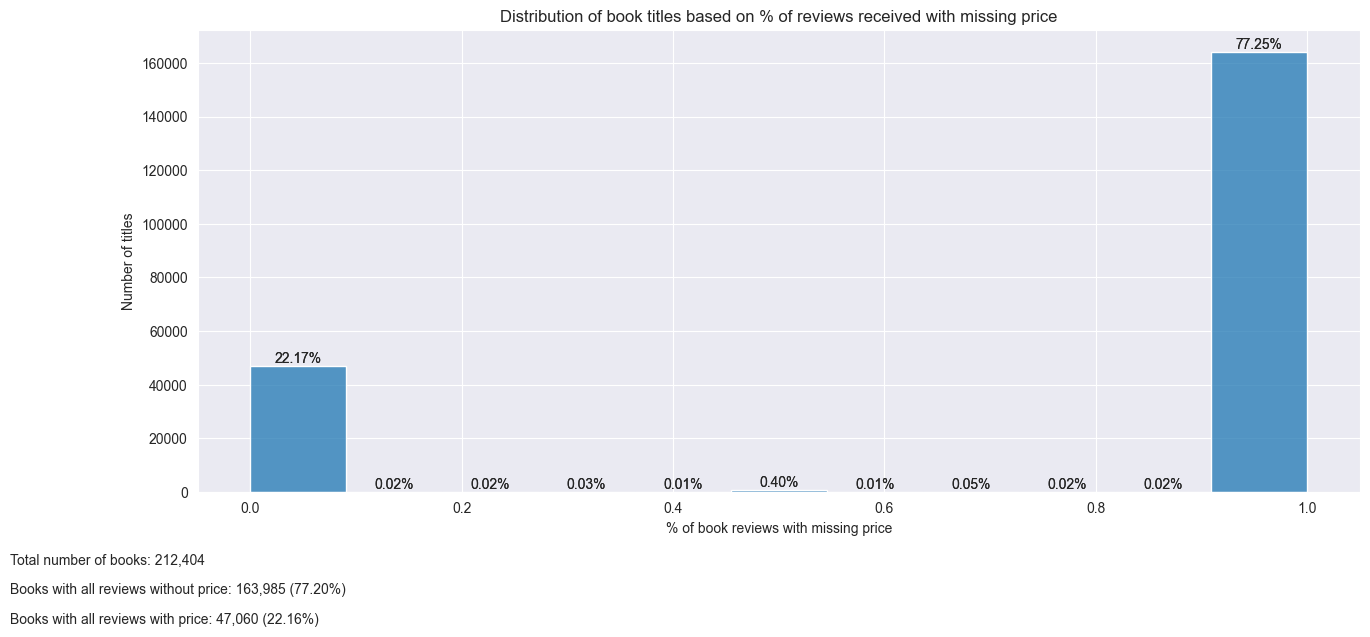

In [35]:
# Set style to darkgrid
sns.set_style("darkgrid")

# Draw histogram using Seaborn
plt.figure(figsize=(15, 6))

ax = sns.histplot(
    data=title_level_df, 
    x='percentage missing prices', 
    bins=n_bins, 
    kde=False)

plt.xlabel('% of book reviews with missing price')
plt.ylabel('Number of titles')
plt.title('Distribution of book titles based on % of reviews received with missing price')

# Compute the counts for each bin
counts, _ = np.histogram(title_level_df['percentage missing prices'], bins=n_bins)
counts = counts / len(title_level_df)  # Convert counts to percentages

# Add text on each column showing the % of observations in each bin
for rect, count in zip(ax.patches, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, f'{count:.2%}', ha='center', va='bottom')

# Add text on each column showing the % of observations in each bin
for rect, count in zip(ax.patches, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, f'{count:.2%}', ha='center', va='bottom')


# Add footnotes
plt.figtext(0, -0.01, f"Total number of books: {tot_books:,}", fontsize=10)
plt.figtext(0, -0.06, f"Books with all reviews without price: {tot_books_no_price:,} ({tot_books_no_price_perc:.2%})", fontsize=10)
plt.figtext(0, -0.11, f"Books with all reviews with price: {tot_books_all_price:,} ({tot_books_all_price_perc:.2%})", fontsize=10)

plt.show()


In [36]:
# # Histogram settings
# bin_size = 0.1
# n_bins = int(1/bin_size)+1

# # Footnotes
# tot_books = title_level_df['reviews number'].count()
# tot_books_no_price = title_level_df[title_level_df['percentage missing prices'] == 1]['Title'].count()
# tot_books_all_price = title_level_df[title_level_df['percentage missing prices'] == 0]['Title'].count()
# tot_books_no_price_perc = tot_books_no_price/tot_books
# tot_books_all_price_perc = tot_books_all_price/tot_books

# # Set up figure
# fig = go.Figure()

# # Draw histogram
# histogram_trace = go.Histogram(
#         x = title_level_df['percentage missing prices'],
#         xbins=dict(
#             # start = ratings_per_title_and_na_prices['percentage missing prices'].min(), 
#             # end = ratings_per_title_and_na_prices['percentage missing prices'].max(), 
#             size = bin_size),
#         name = "% of ratings with missing price")

# # Compute the counts for each bin
# counts, bins = np.histogram(
#     title_level_df['percentage missing prices'], 
#     bins=n_bins)

# counts = [c/tot_books for c in counts]
# # Format the counts with thousands separator
# formatted_counts = [f"{count:.2%}" for count in counts]

# # Add the counts as text to the bars
# histogram_trace.text = formatted_counts

# # Add the histogram trace to the figure
# fig.add_trace(histogram_trace)

# # Add title and footnotes
# fig.update_layout(
#     # Title
#     title_text="Distribution of book titles based on % of reviews received with missing price",
#     title_font_size=20,
#     title_x=0.5,
#     title_y=0.95,
#     # Axis titles
#     yaxis_title="Number of titles",
#     xaxis_title = "% of book reviews with missing price",
#     # Footnotes
#     annotations=[
#         dict(
#             x=0,
#             y=-0.15,
#             xref="paper",
#             yref="paper",
#             text=f"Total number of books: {tot_books:,}",
#             showarrow=False,
#             font=dict(size=12)
#         ),
#         dict(
#             x=0,
#             y=-0.2,
#             xref="paper",
#             yref="paper",
#             text=f"Books with all reviews without price: {tot_books_no_price:,} ({tot_books_no_price_perc:.2%})",
#             showarrow=False,
#             font=dict(size=12)
#         ),
#         dict(
#             x=0,
#             y=-0.25,
#             xref="paper",
#             yref="paper",
#             text=f"Books with all reviews with price: {tot_books_all_price:,} ({tot_books_all_price_perc:.2%})",
#             showarrow=False,
#             font=dict(size=12)
#         )
#     ]
# )

# fig.show()

-> Questions/Note:
- we may not be able to use price in the model

### 2.3 Review date

In [37]:
# Convert to datetime
amz_ratings['review_date_clean'] = amz_ratings['review/time'].apply(ratings_cleaning_steps.review_time_conversion)

In [38]:
amz_ratings['year'] = amz_ratings['review_date_clean'].dt.year

In [39]:
# Dates should all be between May 1996 - July 2014
print(amz_ratings['review_date_clean'].min(), amz_ratings['review_date_clean'].max())

1969-12-31 23:59:59 2013-03-04 00:00:00


In [40]:
# Look at the number of reviews per year
amz_ratings.groupby('year')['Id'].count()

year
1969        21
1995       267
1996      6307
1997     41786
1998    123989
1999    221566
2000    224550
2001    189822
2002    184622
2003    177124
2004    178292
2005    204774
2006    192886
2007    170188
2008    143528
2009    152264
2010    158615
2011    171331
2012    297992
2013    160076
Name: Id, dtype: int64

<Axes: xlabel='year', ylabel='Count'>

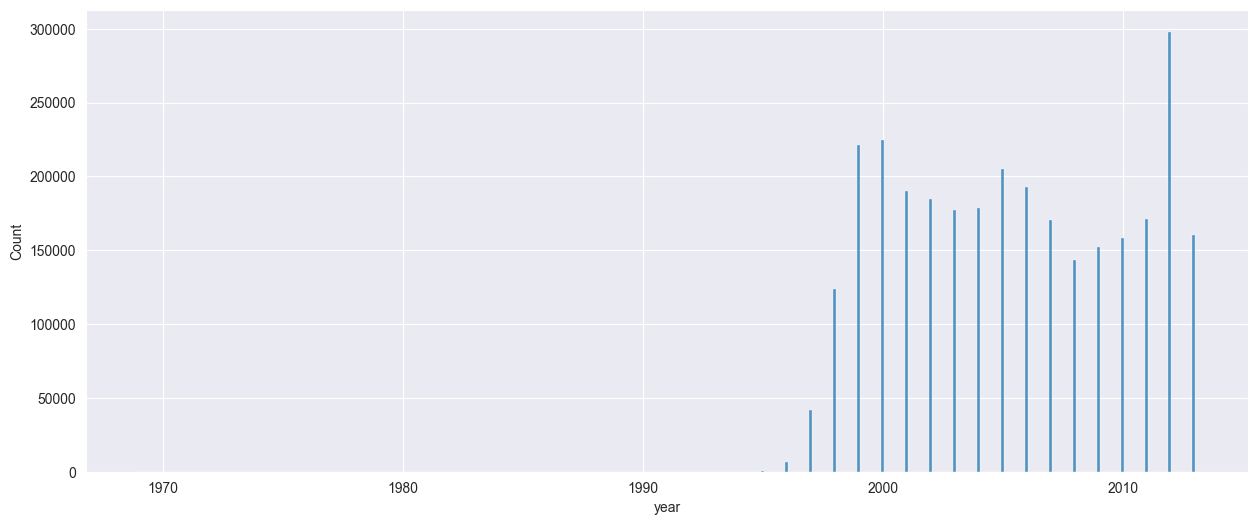

In [41]:
# Set style to darkgrid
sns.set_style("darkgrid")

# Draw histogram using Seaborn
plt.figure(
    figsize = (15, 6))

sns.histplot(
    data = amz_ratings,
    x = 'year'
)

In [42]:
# Explore book published in 2030
amz_ratings[amz_ratings['Title'] == 'A Wealth of Wisdom: Legendary African American Elders Speak']

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review_date_clean,year
1384321,B000HXDKD4,A Wealth of Wisdom: Legendary African American...,11.18,A1FBD9R1Z8EI9F,Dr. Rene Thomas,16/17,5.0,1074384000,Wealth of Knowledge - History's Truths,Thanks to Dr. Cosby and Renee Pouissant we now...,2004-01-18,2004
1384322,B000HXDKD4,A Wealth of Wisdom: Legendary African American...,11.18,A1O9BT8V9SQL3V,AfroAmericanHeritage,6/6,5.0,1076544000,Couldn't Put It Down,This is one of those rare books I simply could...,2004-02-12,2004
1384323,B000HXDKD4,A Wealth of Wisdom: Legendary African American...,11.18,ADJBUPS8SJHTC,"thesavvybamalady ""swblkdiamond""",6/6,4.0,1075939200,Enjoyed It!!,I enjoy reading this book. Really. The reason ...,2004-02-05,2004
1384324,B000HXDKD4,A Wealth of Wisdom: Legendary African American...,11.18,A3M4BPIG8MABTJ,Lin Werner,4/4,5.0,1077494400,Great Advise,This is a wonderful book of advice from wise A...,2004-02-23,2004
1384325,B000HXDKD4,A Wealth of Wisdom: Legendary African American...,11.18,A3PUGA2RSMSNTB,sedpj,0/0,5.0,1355702400,Women's Wit,So many women sharing views through their own ...,2012-12-17,2012


Questions/Notes:
- the dates do not match the period indicated in the metadata (data set contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.)
- there is a mismatch between the published date in teh amazon books dataset and the date of the reviews.

In [60]:
# Create dataset to store min and max date
min_review_date = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings,
    group_by_columns = 'Title',
    col_to_aggregate= 'review_date_clean',
    operation = 'min',
    new_name_for_col_aggregated = 'min review date'
)

max_review_date = ratings_cleaning_steps.aggregate_df(
    df = amz_ratings,
    group_by_columns = 'Title',
    col_to_aggregate= 'review_date_clean',
    operation = 'max',
    new_name_for_col_aggregated = 'max review date'
)

# Add to title_level_df
df_list = [min_review_date, max_review_date]

for df in df_list:
    title_level_df = pd.merge(
        title_level_df,
        df,
        on = 'Title',
        how ='left'
    )

### 2.4 Book ratings

#### 2.4.1 Distribution of books based on the number of ratings they received

In [61]:
# Create dataset to zoom on obs with ratings bwloe the 75th percentile
perc_75 = title_level_df['reviews number'].quantile(0.75)
no_outliers_count_ratings = title_level_df[
    (title_level_df['reviews number'] <= perc_75)]

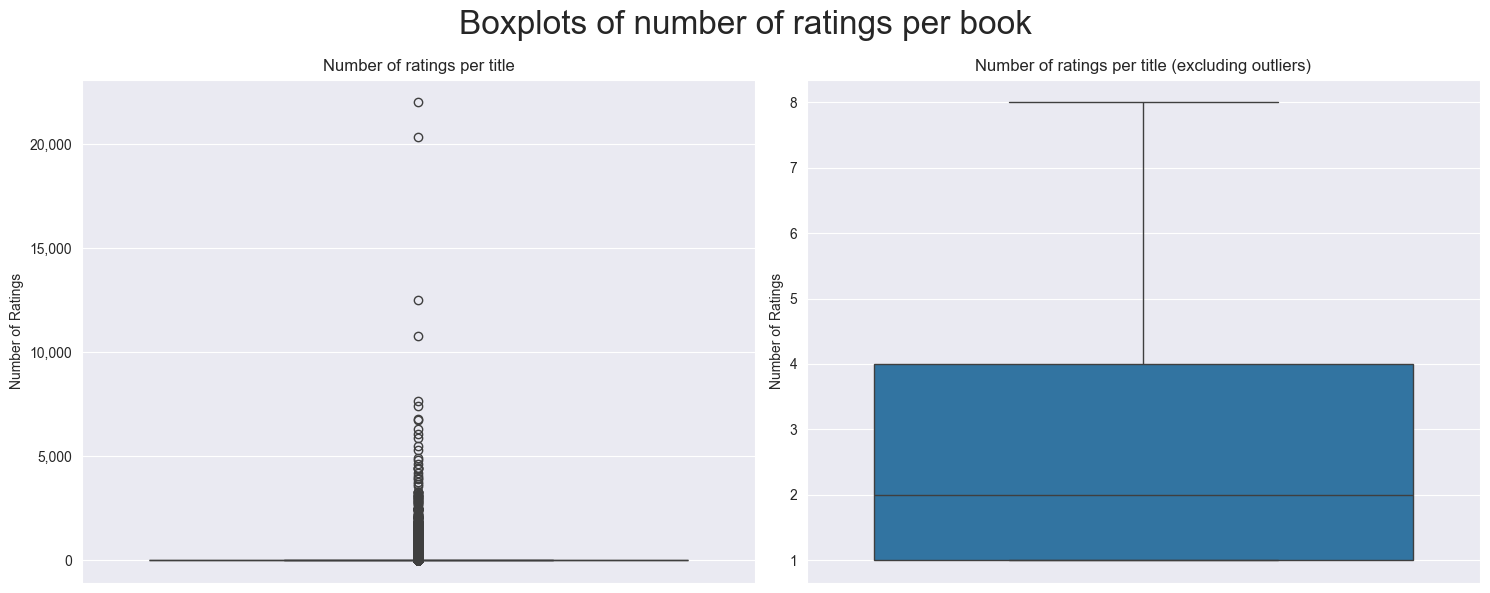

In [62]:
from matplotlib.ticker import FuncFormatter

# Create subplots
fig, axes = plt.subplots(
    1, 
    2, 
    figsize=(15, 6))

# Plot boxplots of full dataset
sns.boxplot(
    y=title_level_df['reviews number'], 
    ax=axes[0])
axes[0].set_title('Number of ratings per title')
axes[0].set_ylabel('Number of Ratings')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Add thousands separator

# Plot boxplots excluding data with ratings > 2.5 std deviation
sns.boxplot(
    y=no_outliers_count_ratings['reviews number'], 
    ax=axes[1])
axes[1].set_title('Number of ratings per title (excluding outliers)')
axes[1].set_ylabel('Number of Ratings')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Add thousands separator

# Set common title for the figure
plt.suptitle("Boxplots of number of ratings per book", fontsize=24)

plt.tight_layout()
plt.show()


In [63]:
# # Create subplots
# fig = make_subplots(
#     rows=1, 
#     cols=2)


# # Plot boxplots of full dataset
# fig.add_trace(
#     go.Box(y=title_level_df['reviews number'], 
#            name='Number of ratings per title',
#            showlegend=False),
#     row = 1,
#     col=1
#     )

# # Plot boxplots excluding data with ratings > 2.5 std deviation
# fig.add_trace(
#     go.Box(y=no_outliers_count_ratings['reviews number'], 
#            name='Number of ratings per title (excluding outliers)',
#            showlegend=False),
#     row = 1,
#     col=2
#     )

# # Update layout to add titles
# fig.update_layout(
#     title_text="Boxplots of number of ratings per book",
#     title_font_size=24,
#     title_x=0.5,
#     title_y=0.95,
#     yaxis_title="Number of Ratings"
# )

# fig.show()


-> Questions/notes:
Few books have a high number of ratings, while 75th percent of the books have between 1 and 8 ratings.
Question: do we want to take only those books with high number of ratings?
For example below is the number of books with at least 100 reviews:

In [64]:
print(f"Number of books with at least 100 ratings:{title_level_df[title_level_df['reviews number'] >= 100]['reviews number'].count(): ,}")

Number of books with at least 100 ratings: 4,024


#### 2.3.2 Distribution of the average rating

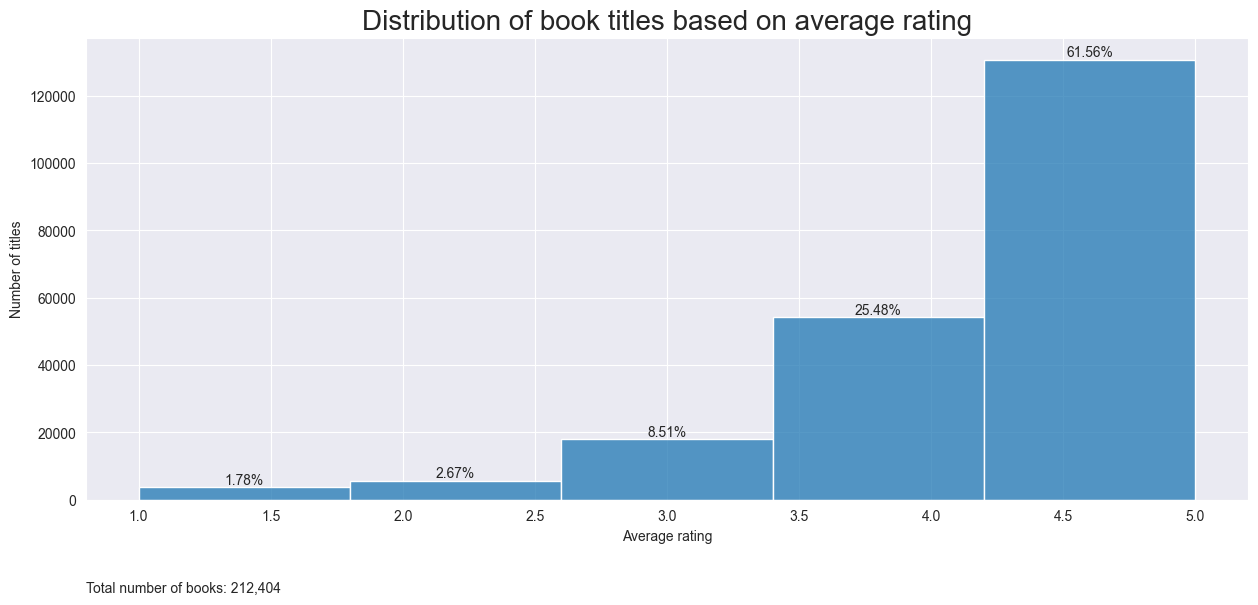

In [65]:
# Set up number of bins
n_bins = 5

# Create a new figure
plt.figure(
    figsize = (15, 6))

# Draw histogram using Seaborn
ax = sns.histplot(title_level_df['average rating'], bins=n_bins, kde=False)

# Compute the counts for each bin
counts, _ = np.histogram(title_level_df['average rating'], bins=n_bins)
counts = counts / len(title_level_df)  # Convert counts to percentages

# Add text on each column showing the % of observations in each bin
for rect, count in zip(ax.patches, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, f'{count:.2%}', ha='center', va='bottom')

# Add title and footnotes
plt.title("Distribution of book titles based on average rating", fontsize=20)
plt.xlabel("Average rating")
plt.ylabel("Number of titles")

# Add footnote
plt.text(0, -0.2, f"Total number of books: {tot_books:,}", fontsize=10, transform=ax.transAxes)

plt.show()


In [66]:
# # Set up number of bins
# n_bins = 5

# # Create a new figure
# fig = go.Figure()

# # Add histogram trace to the figure with 10 bins
# histogram_trace = go.Histogram(x=title_level_df['average rating'], 
#                                nbinsx=n_bins, 
#                                name="avg rating distribution")

# # Compute the counts for each bin
# counts, bins = np.histogram(
#     title_level_df['average rating'], 
#     bins=n_bins)

# counts = [c/title_level_df['Title'].count() for c in counts]
# # Format the counts with thousands separator
# formatted_counts = [f"{count:.2%}" for count in counts]

# # Add the counts as text to the bars
# histogram_trace.text = formatted_counts

# # Add the histogram trace to the figure
# fig.add_trace(histogram_trace)

# # Update layout
# fig.update_layout(
#     title_text="Distribution of book titles based on average rating",
#     title_font_size=20,
#     title_x=0.5,
#     title_y=0.95,
#     yaxis_title="Number of titles",
#     xaxis_title="Average rating",
#     annotations=[
#         dict(
#             x=0,
#             y=-0.2,
#             xref="paper",
#             yref="paper",
#             text=f"Total number of books: {tot_books:,}",
#             showarrow=False,
#             font=dict(size=12)
#         )
#     ]
# )

# # Show the figure
# fig.show()


-> Questions/notes:
- most books have a 4 and 5 rating
    - could this skewed ditribution impact our analysis?

#### 2.3.3 Average vs median price

Text(0, 0.5, 'Average rating')

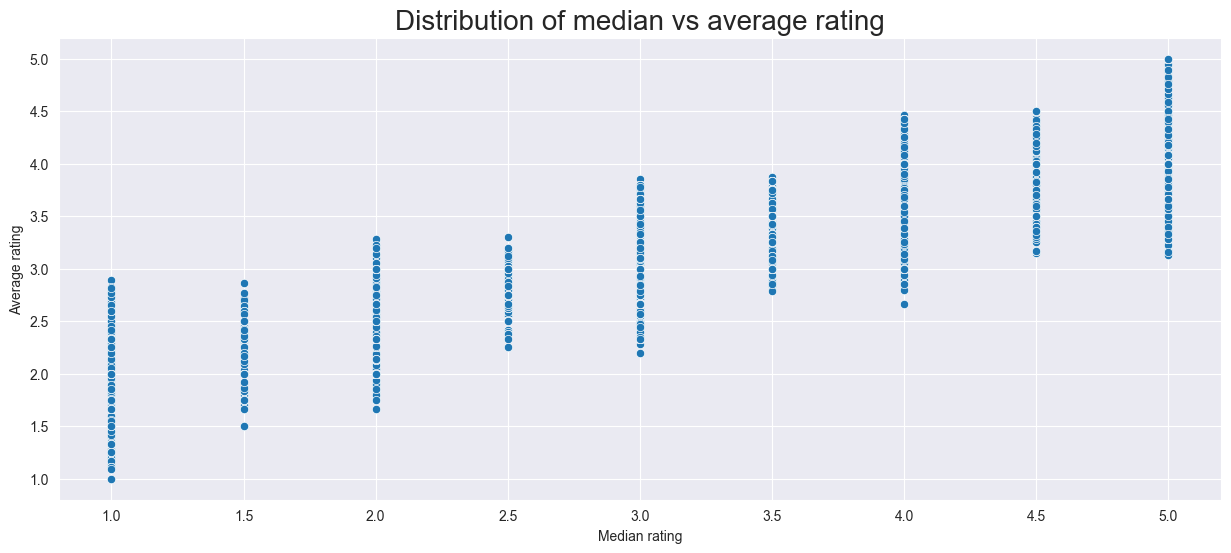

In [67]:
# Create a new figure
plt.figure(
    figsize = (15, 6))

sns.scatterplot(
    data = title_level_df,
    x = 'median rating',
    y = 'average rating'
)

# Add title and footnotes
plt.title("Distribution of median vs average rating", fontsize=20)
plt.xlabel("Median rating")
plt.ylabel("Average rating")

-> Questions/Notes:
- there is some variability between median and average ratings. in some cases the difference between the two can be even of 2 points. We may want to run the model on both?

### 2.4 Price

#### 2.4.1 Price distribution

In [68]:
# Create dataset to zoom on obs with ratings bwloe the 75th percentile
perc_75 = amz_ratings['Price'].quantile(0.75)
no_outliers_count_ratings = amz_ratings[
    (amz_ratings['Price'] <= perc_75)]

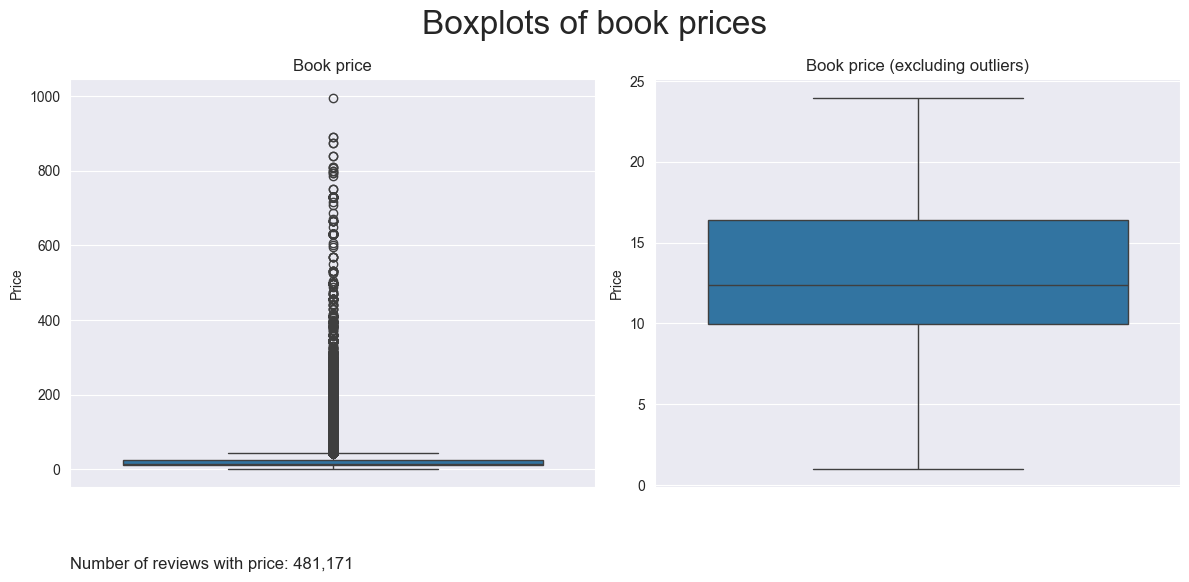

In [69]:
# Create subplots
fig, axes = plt.subplots(
    1, 
    2, 
    figsize=(12, 6))

# Plot boxplots of full dataset
sns.boxplot(
    data = amz_ratings,
    y = 'Price',
    ax=axes[0]
)
axes[0].set_title('Book price')
axes[0].set_ylabel('Price')

# Plot boxplots excluding data with ratings > 2.5 std deviation
sns.boxplot(
    data = no_outliers_count_ratings,
    y = 'Price',
    ax=axes[1]
)
axes[1].set_title('Book price (excluding outliers)')
axes[1].set_ylabel('Price')

# Add annotation
axes[0].text(0, -0.2, f"Number of reviews with price: {amz_ratings['Price'].count():,}", fontsize=12, transform=axes[0].transAxes)

# Set common title for the figure
plt.suptitle("Boxplots of book prices", fontsize=24)

plt.tight_layout()
plt.show()


In [70]:
# # Create subplots
# fig = make_subplots(
#     rows=1, 
#     cols=2)


# # Plot boxplots of full dataset
# fig.add_trace(
#     go.Box(y=amz_ratings['Price'], 
#            name='Book price',
#            showlegend=False),
#     row = 1,
#     col=1
#     )

# # Plot boxplots excluding data with ratings > 2.5 std deviation
# fig.add_trace(
#     go.Box(y=no_outliers_count_ratings['Price'], 
#            name='Book price (excluding outliers)',
#            showlegend=False),
#     row = 1,
#     col=2
#     )

# # Update layout to add titles
# fig.update_layout(
#     title_text="Boxplots of book prices",
#     title_font_size=24,
#     title_x=0.5,
#     title_y=0.95,
#     yaxis_title="Number of Ratings",
#     annotations=[
#         dict(
#             x=0,
#             y=-0.2,
#             xref="paper",
#             yref="paper",
#             text=f"Number of reviews with price: {amz_ratings['Price'].count():,}",
#             showarrow=False,
#             font=dict(size=12)
#         )
#     ]
# )

# fig.show()


75% of the books cost less tahn 25 (currencty unknown). Others go well above the hundreds.

In [71]:
amz_ratings[amz_ratings['Price']>500]

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review_date_clean,year
80423,0700714480,The Collected Works of J.G. Frazer: The Golden...,630.00,A2MVLMIKJFR1Z6,ashlynn@paganism.com,6/9,4.0,890611200,Get it!,Sir James George Frazer (1854-1941) was a Scot...,1998-03-23,1998
80424,0700714480,The Collected Works of J.G. Frazer: The Golden...,630.00,A3MKDM7UE1XGMV,Milarepa,2/3,5.0,1221782400,Required Reading,I don't know what to say. Recommending this bo...,2008-09-19,2008
80425,0700714480,The Collected Works of J.G. Frazer: The Golden...,630.00,A3TISNN4BIWW2Y,ROBERT L WOODLEY,2/3,4.0,1052092800,Great detail. Overall premise seems dated,"A root text in cultural anthropology, but date...",2003-05-05,2003
80426,0700714480,The Collected Works of J.G. Frazer: The Golden...,630.00,A370Z6I5GBWU44,"M ""CultOfStrawberry""",0/0,5.0,1262822400,A must-have reference book,"For anyone serious about mythology, folklore, ...",2010-01-07,2010
80427,0700714480,The Collected Works of J.G. Frazer: The Golden...,630.00,A2A3C6AH7DX0ZX,Motty Perel,22/34,5.0,1012435200,Man's blunders on the way to knowledge.,"Given the limited time I had to read the book,...",2002-01-31,2002
...,...,...,...,...,...,...,...,...,...,...,...,...
2707441,0966934520,Standard Warehouse Management System Search Bu...,795.00,A38N7ZX7KOO6JS,Rick Howard,1/1,5.0,999129600,GREAT ASSISTANCE in our WMS search and selecti...,These tools assisted us in locating Unix & NT ...,2001-08-30,2001
2827420,0415037859,Companion Encyclopedia of the History and Phil...,716.63,A3GG15WXX2ATQH,"August Vandevoorde ""augvan""",0/0,5.0,1275350400,Most Comprehensive,"I have dozens, perhaps hundreds but certainly ...",2010-06-01,2010
2890452,1853128317,Ekranoplanes: Controlled Flight Close to the S...,570.00,AHYT7NF6Z5D7Q,Dr. Richard Colgren,3/3,4.0,1039824000,Ekranoplanes,"The book, Ekranoplanes: Controlled Flight Clos...",2002-12-14,2002
2995521,1886363307,"The Iconography of Manhattan Island, 1498-1909...",750.00,A2E5PM02QQFCWK,rkchin,2/3,5.0,1105574400,Original source material,The information contained in these six books i...,2005-01-13,2005


-> Questions/Notes:
- The most expensive books seem to be collections or handbooks. So it seems reasonable to expect these to be more expensive.
- There could still be a chance that highest values are due to different currencies in the dataset, which is not specified in the  kaggle source.

## 3 Feature engineering
There are alternatives metrics for ratings:
WR = [(v * R)/(v + m)] + [(m * c)/(v + m)]  

where,
- v is the number of votes for the books;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the book; and
- C is the mean vote across the whole report.  

Source: 
- [Sweta Singh - Book recommendation system (2021)](https://shwetasingh8597.medium.com/book-recommendation-system-1679ed4f9f6d)
- [Hargurjeet - What Should I Read Next? Books Recommendation (2021)](https://shwetasingh8597.medium.com/book-recommendation-system-1679ed4f9f6d)
- [krishnaik06](https://github.com/krishnaik06/Recommendation_complete_tutorial/blob/master/Average%20Weighted%20Recommendation%20Engines%20using%20Python.ipynb)

-> Questions/notes:
- Some research suggests that this is IMDBs weighting approach. This is supposed to take into account the number of votes that an item receives.

In [72]:
title_level_df['weighted rating'] = ratings_cleaning_steps.weighted_rating(
    titles_df = title_level_df,
    n_of_reviews_column='reviews number',
    avg_rating_column = 'average rating',
    quantile_for_min_votes= 0.90
)

Text(0.5, 0.98, 'Weighted rating vs median and average ratings')

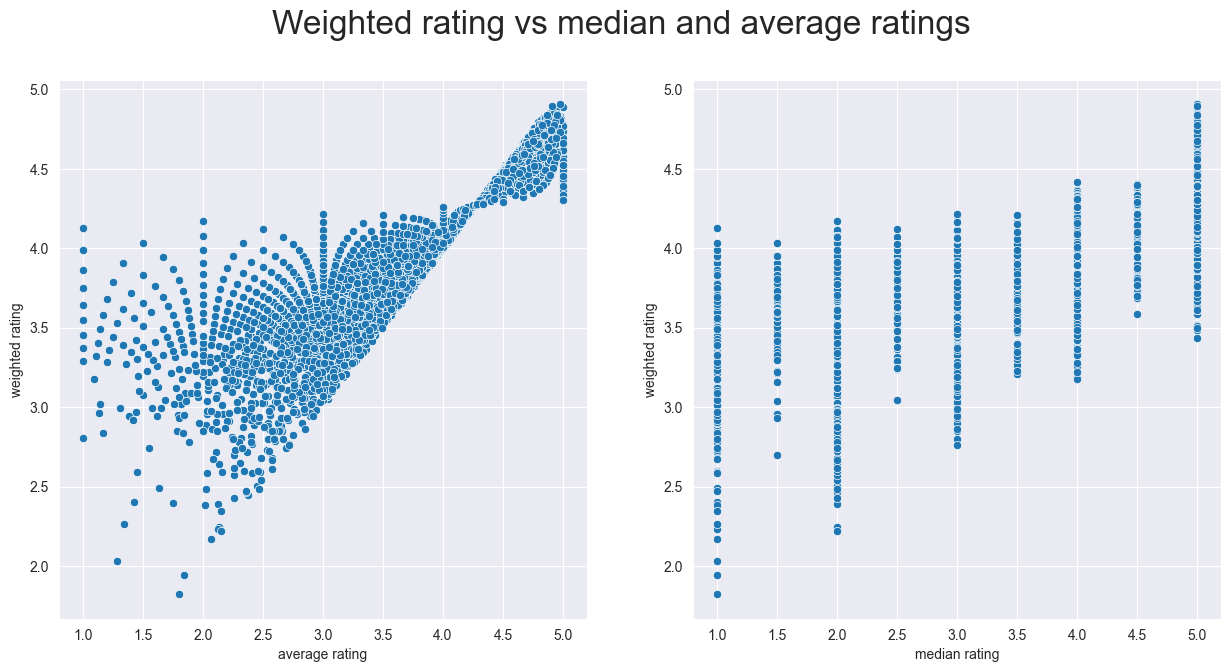

In [73]:
# Create subplot
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(15,7)
)
sns.scatterplot(
    data = title_level_df,
    x = 'average rating',
    y = 'weighted rating',
    ax = axes[0]
)

sns.scatterplot(
    data = title_level_df,
    x = 'median rating',
    y = 'weighted rating',
    ax = axes[1]
)

plt.suptitle("Weighted rating vs median and average ratings", fontsize=24)


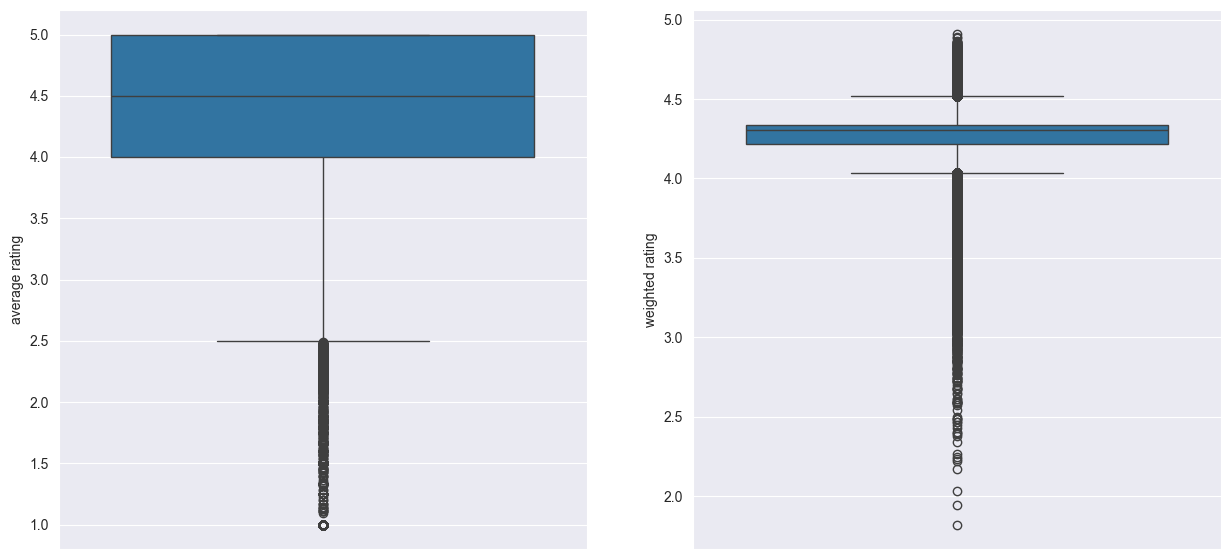

In [74]:
# Create subplot
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(15,7)
)

sns.boxplot(
    data = title_level_df,
    y = 'average rating',
    ax = axes[0]
)

sns.boxplot(
    data = title_level_df,
    y = 'weighted rating',
    ax = axes[1]
)

plt.show()

## 4 Export title-level dataset

In [75]:
title_level_df.to_csv(
    path_or_buf = os.path.join(output_folder, "book_ratings_info.csv"),
    index = False
)